In [1]:
'''
마지막 수정: 2024.12.14 20:33

[주의] 
!!!! 아직 dropout_data 만드는 중! 어디까지 만들었는지 확인하고 코드 돌리세요 존재 안하는 폴더 있을수도 !!!!
!!!!!dropout_data의 X는 sparse array, int32으로 통일했습니다.!!!!!!
!!!! adata 모두 normalize/log 했습니다. 전에 없던 오류가 생겼으면 얘가 원인일수도... !!!
봐서 알겠지만 원본/dropout 파일들의 이름이 같습니다. 코딩하기 편하려고 통일했으니
아무쪼록 헷갈리지 마시길...
dropout_data에 layers/dropped가 추가되어있습니다. X랑 같은 모양으로 boolean 
형식이고, True인 데이터들이 drop 후 0으로 채운 위치입니다. 혹시 모델이 NaN을
더 잘 impute한다면 이거 이용해서 데이터 수정하시면 됩니다.
모델 별로 이 노트북을 새로 복제해서 만들어두면 나중에 배포용 코드 만들기 편하겠죠?
이미지 파일이 필요하시면 hest_data/wsis 에서 가져오셔야 합니다. SPROD에 제가 만들어둔 가져오는
코드가 있긴 하니 필요하시면 가져가시죠.
이왕이면 dropout_data 폴더는 수정하지 말아주세요 (output 저장 포함)

결과는 bench_results에 저장됩니다. 혹시 잘못 돌려서 데이터 삭제해야하면 수동으로 들어가서 수정하시죠 ㅎ

[수정] 이라고 코멘트 해 둔 부분 적절히 고치시면 됩니다.
'''

'\n마지막 수정: 2024.12.14 20:33\n\n[주의] \n!!!! 아직 dropout_data 만드는 중! 어디까지 만들었는지 확인하고 코드 돌리세요 존재 안하는 폴더 있을수도 !!!!\n!!!!!dropout_data의 X는 sparse array, int32으로 통일했습니다.!!!!!!\n!!!! adata 모두 normalize/log 했습니다. 전에 없던 오류가 생겼으면 얘가 원인일수도... !!!\n봐서 알겠지만 원본/dropout 파일들의 이름이 같습니다. 코딩하기 편하려고 통일했으니\n아무쪼록 헷갈리지 마시길...\ndropout_data에 layers/dropped가 추가되어있습니다. X랑 같은 모양으로 boolean \n형식이고, True인 데이터들이 drop 후 0으로 채운 위치입니다. 혹시 모델이 NaN을\n더 잘 impute한다면 이거 이용해서 데이터 수정하시면 됩니다.\n모델 별로 이 노트북을 새로 복제해서 만들어두면 나중에 배포용 코드 만들기 편하겠죠?\n이미지 파일이 필요하시면 hest_data/wsis 에서 가져오셔야 합니다. SPROD에 제가 만들어둔 가져오는\n코드가 있긴 하니 필요하시면 가져가시죠.\n이왕이면 dropout_data 폴더는 수정하지 말아주세요 (output 저장 포함)\n\n결과는 bench_results에 저장됩니다. 혹시 잘못 돌려서 데이터 삭제해야하면 수동으로 들어가서 수정하시죠 ㅎ\n\n[수정] 이라고 코멘트 해 둔 부분 적절히 고치시면 됩니다.\n'

패키지 업로드

In [1]:
import anndata as ad
import os
import numpy as np
import torch
from scipy.sparse import csr_matrix
import scanpy as sc


#[수정] 이 밑으로 [여기까지] 지우고 여러분 모델에 맞는 패키지 불러오시면 됩니다.
import sys
from ReST import ReST
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#[여기까지]

벤치마킹 데이터/환경 세팅

In [2]:
bench_data_dir = '/home/s2022310812/bench_data' # bench_data 경로 [수정]
dropout_data_dir = '/home/s2022310812/dropout_data' #dropout_data 경로 [수정]
datasets = [ #[수정]
    "IDC",
  # "COAD",
  # "READ",
  # "LYMPH_IDC",
]
model = "MIST" #[수정] 모델명
percents = [ #[수정] dropout percentage
    #'10%',
    #'20%',
    '30%'
] 
samples = [ #[수정] dropout percentage data version
    '1',
    #'2',
    #'3',
    #'4',
    #'5'
] 

trial = '1' #[수정] dropout percentage data version trial number (1-5)
man_sc = {}
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu') #[수정] cuda:사용할 GPU

벤치마킹 모델 구동

Before QC: 4180 observations and 541 genes.
After QC: 4180 observations and 541 genes.
MIST Data created in 99.16 seconds.


100%|█████████████████████| 43/43 [02:15<00:00,  3.14s/it]


Epsilon 0.740 is selected in 139.14 seconds.
Graph constructed.
Neighbors extracted.
{'IDC/NCBI785.h5ad': 2.1003187015318248}
Before QC: 3869 observations and 541 genes.
After QC: 3869 observations and 541 genes.


KeyboardInterrupt: 

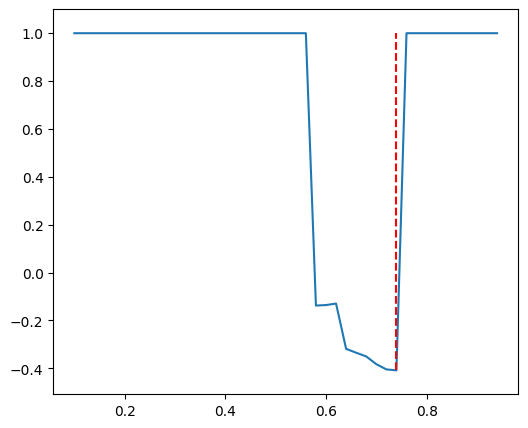

In [4]:
for dataset in datasets:
    for percent in percents:
        for sample in samples:
            bench_path = os.path.join(bench_data_dir,dataset,'adata')
            dropout_path = os.path.join(dropout_data_dir,dataset,percent+"-"+sample)
            
            adata_names = [f for f in os.listdir(bench_path) if os.path.isfile(os.path.join(bench_path, f))]
        
            for adata_name in adata_names:

                adata = ad.read_h5ad(os.path.join(bench_path,adata_name))
                sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed= False) 
                sc.pp.log1p(adata)
                sc.pp.scale(adata)
                
                adata_drop = ad.read_h5ad(os.path.join(dropout_path,adata_name))
                sc.pp.normalize_total(adata_drop, target_sum=1e6, exclude_highly_expressed= False)
                sc.pp.log1p(adata_drop)
                sc.pp.scale(adata_drop)
                    
                dropped_mask = torch.tensor(adata_drop.layers['dropped'], dtype=torch.bool, device=device)
                
                """
                [수정]
                여기서부터 [여기까지] adata_drop.X에 본인 모델 적용시켜서 adata2에 저장해주시면 됩니다.
                [주의] adata2에 ""adata.X 에 해당하는 파일"" 저장해주세요... 그냥 그렇게 만들었어요..
                예시로 제 코드 보여드림. 여러분한테는 쓸모가 없겠죠? 지우고 시작하시면 됩니다 화이팅
                """
                spatial_coords = adata.obsm['spatial']
                gene_expression = adata.X  # Expression matrix
                gene_names = adata.var_names  # Gene symbols
        
                # Create a DataFrame with spatial coordinates as the index and gene symbols as columns
                df = pd.DataFrame(gene_expression, columns=gene_names, index=[f"{x},{y}" for x, y in spatial_coords])
        
                df.columns = [c.split()[0] for c in df.columns]
                xs, ys = [],[]
                for ind in df.index.tolist():
                    xs.append(int(float(ind.split(',')[0])))
                    ys.append(int(float(ind.split(',')[1])))
                meta_df = pd.DataFrame({'array_col': xs, "array_row": ys}, index = df.index)
                gene_df = pd.DataFrame({'gene': df.columns.tolist()}, index=df.columns)
                
                ## Data construction, QC, and preprocessing
                rd = ReST(adata=adata_drop)
                rd.preprocess(species='Human', hvg_prop=0.8, n_pcs=10)
                #rd.extract_regions(min_sim = 0.1, min_size=20, gap=0.02)
                #rd.runGSEA(mode='all', species='Human', gene_sets="GO_Biological_Process_2021")
                adata2 = rd.impute(ncores=1, nExperts=3)
                """
                [여기까지]
                """
                
                
                
                # Step 1: Convert adata.X to float32 or int32 before creating the PyTorch tensor
                if isinstance(adata.X, np.ndarray):
                    # Convert to float32 if data is uint16 or other unsupported types
                    adata_X = adata.X.astype(np.float32) if adata.X.dtype == np.uint16 else adata.X.astype(np.float32)
                    adata_tensor = torch.tensor(adata_X, dtype=torch.float32, device=device)
                elif isinstance(adata.X, csr_matrix):
                    adata_X = adata.X.toarray().astype(np.float32)
                    adata_tensor = torch.tensor(adata_X, dtype=torch.float32, device=device)
                else:
                    print('adata.X 데이터 형식 확인해주세요')
                    
                # Step 2: Convert adata2 to float32 or int32 before creating the PyTorch tensor
                if isinstance(adata2, np.ndarray):
                    # Convert to float32 if data is uint16 or other unsupported types
                    adata2 = adata2.astype(np.float32) if adata2.dtype == np.uint16 else adata2.astype(np.float32)
                    adata2_tensor = torch.tensor(adata2, dtype=torch.float32, device=device)
                elif isinstance(adata2, csr_matrix):
                    adata2 = adata2.toarray().astype(np.float32)
                    adata2_tensor = torch.tensor(adata2, dtype=torch.float32, device=device)
                elif isinstance(adata2, pd.DataFrame):
                    # Convert to NumPy array, ensure it's float32
                    adata2 = adata2.values.astype(np.float32)
                    adata2_tensor = torch.tensor(adata2, dtype=torch.float32, device=device)
                else:
                    print('adata2 데이터 형식 확인해주세요')
            
                # Step 3: Get the indices of the dropped values (where the mask is True)
                dropped_indices = dropped_mask.nonzero(as_tuple=True)
                
                # Step 4: Extract the corresponding values for dropped spots
                adata_values = adata_tensor[dropped_indices]
                adata2_values = adata2_tensor[dropped_indices]
                
                # Step 5: Convert to CPU and calculate manh.
                adata_values_cpu = adata_values.cpu().numpy()
                adata2_values_cpu = adata2_values.cpu().numpy()

                manhattan_distance = np.abs(adata_values_cpu - adata2_values_cpu).sum()
                num_values = adata_values_cpu.size
                manhattan_score = manhattan_distance / num_values
                
                # Store the result in the dictionary
                man_sc[dataset + "/" + adata_name] = manhattan_score
                
                print(man_sc)

            row_name = "Trial : " + trial
            my_dir = os.path.join('/home/s2022310812/bench_results', model,dataset)
            csv_path = os.path.join(my_dir, percent+"-"+sample +"_result.csv")
            # Ensure the directory exists
            os.makedirs(my_dir, exist_ok=True)
            
            # Extract column names and values
            columns = [key.split("/")[-1].split(".")[0] for key in man_sc.keys()]
            values = list(man_sc.values())
            
            # Create a DataFrame for the new row
            data = pd.DataFrame([values], columns=columns, index=[row_name])
            
            # Check if the file exists
            if os.path.exists(csv_path):
                # Read the existing CSV
                existing_data = pd.read_csv(csv_path, index_col=0)
            
                # Append the new row
                updated_data = pd.concat([existing_data, data])
            else:
                # If the file doesn't exist, use the new DataFrame
                updated_data = data
            
            # Save back to CSV
            updated_data.to_csv(csv_path) # [수정] 파라미터 최적화 등 결과 저장하지 않고 돌려보는 단계면 이 줄 주석처리
